In [1]:
import os

os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [2]:
import pandas as pd
import re

df = pd.read_csv("Gutenberg-Poetry.csv", on_bad_lines='skip')
poems = df['s'].dropna().tolist()

# Clean each poem line
cleaned_poems = [re.sub(r"[^a-zA-Z0-9.,;:'\"()\s\-?!]", '', str(p).lower()) for p in poems if len(p.strip()) > 0]

joined_poems = "\n".join(cleaned_poems)

# Save to file
with open("data/cleaned_poetry.txt", "w", encoding="utf-8") as f:
    f.write(joined_poems)


In [3]:
from transformers import GPT2Tokenizer
from datasets import Dataset

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

lines = joined_poems.split("\n")
dataset = Dataset.from_dict({"text": lines})

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3085117 [00:00<?, ? examples/s]

In [4]:
from transformers import GPT2LMHeadModel, TrainingArguments, Trainer

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(
    output_dir="models/gpt2-poetry",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    logging_dir="logs",
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

# trainer.train()  # Uncomment to start training


C:\Users\HP\AppData\Local\Temp\ipykernel_19924\2773213080.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [5]:
from transformers import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
output = generator("the sun is rises in the east", max_length=50, do_sample=True, top_p=0.95)

print("Generated Poem:\n", output[0]["generated_text"])


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Generated Poem:
 the sun is rises in the east, and darkness rises in the north; the wind flows through the mountains like a torrent."

From an eyewitness's perspective, this makes us wonder whether the story of the sun setting is an accurate depiction of our


In [6]:
import gradio as gr

def generate_poem(prompt):
    result = generator(prompt, max_length=70, do_sample=True, top_p=0.95)
    return result[0]["generated_text"]

gr.Interface(fn=generate_poem, inputs="text", outputs="text").launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [7]:
!pip install nltk rouge-score


In [8]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

nltk.download("punkt")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# Sample real poetry lines (ground truth)
reference_texts = [
    "the moonlight danced on ocean waves",
    "a rose blooms in quiet grace"
]

# Corresponding model outputs
generated_texts = [
    "moonlight danced across the ocean wide",
    "the rose bloomed with silent pride"
]


In [10]:
smoothie = SmoothingFunction().method4

for ref, gen in zip(reference_texts, generated_texts):
    reference_tokens = [nltk.word_tokenize(ref)]
    generated_tokens = nltk.word_tokenize(gen)
    score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothie)
    print(f"BLEU Score: {score:.4f}")


BLEU Score: 0.1156
BLEU Score: 0.0376


In [11]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for ref, gen in zip(reference_texts, generated_texts):
    scores = scorer.score(ref, gen)
    print(f"\nROUGE Scores for:\nRef: {ref}\nGen: {gen}")
    for metric, value in scores.items():
        print(f"{metric}: Precision={value.precision:.4f}, Recall={value.recall:.4f}, F1={value.fmeasure:.4f}")



ROUGE Scores for:
Ref: the moonlight danced on ocean waves
Gen: moonlight danced across the ocean wide
rouge1: Precision=0.6667, Recall=0.6667, F1=0.6667
rouge2: Precision=0.2000, Recall=0.2000, F1=0.2000
rougeL: Precision=0.5000, Recall=0.5000, F1=0.5000

ROUGE Scores for:
Ref: a rose blooms in quiet grace
Gen: the rose bloomed with silent pride
rouge1: Precision=0.3333, Recall=0.3333, F1=0.3333
rouge2: Precision=0.2000, Recall=0.2000, F1=0.2000
rougeL: Precision=0.3333, Recall=0.3333, F1=0.3333


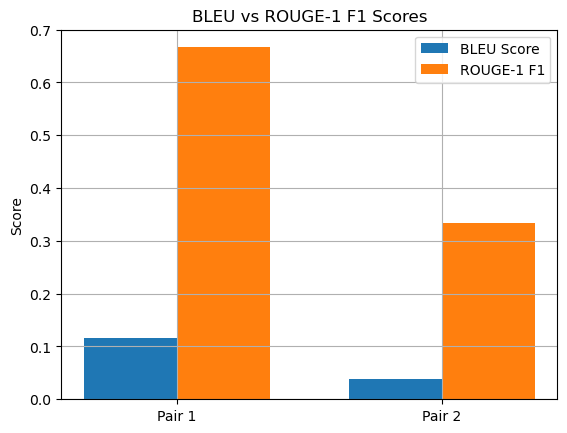

In [12]:
import matplotlib.pyplot as plt

bleu_scores = []
rouge1_f1 = []
labels = []

for i, (ref, gen) in enumerate(zip(reference_texts, generated_texts)):
    reference_tokens = [nltk.word_tokenize(ref)]
    generated_tokens = nltk.word_tokenize(gen)
    bleu = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothie)
    bleu_scores.append(bleu)

    scores = scorer.score(ref, gen)
    rouge1_f1.append(scores['rouge1'].fmeasure)
    labels.append(f"Pair {i+1}")

x = range(len(labels))
width = 0.35

plt.bar(x, bleu_scores, width=width, label='BLEU Score')
plt.bar([i + width for i in x], rouge1_f1, width=width, label='ROUGE-1 F1')
plt.xticks([i + width / 2 for i in x], labels)
plt.ylabel("Score")
plt.title("BLEU vs ROUGE-1 F1 Scores")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from transformers import Trainer


In [14]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, Trainer
from transformers import TrainerCallback
import matplotlib.pyplot as plt


In [15]:
# Custom callback to log loss
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])

loss_logger = LossLoggerCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    callbacks=[loss_logger],  # 👈 added callback
)

# Start training
trainer.train()

# Plot training loss
plt.plot(loss_logger.losses, color="blue")
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_19924\4264955465.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\HP\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ValueError: The model did not return a loss from the inputs, only the following keys: logits,past_key_values. For reference, the inputs it received are input_ids,attention_mask.